# Figure 3

imports

In [30]:
import torch
import numpy as np
import h5py
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from utils.funcs import *
import os, sys

from matplotlib.colors import LogNorm
from scipy.stats import pearsonr
from matplotlib.ticker import LogFormatterExponent

sys.path.append(r'C:\Users\sebas\RU\RBM')
from PGM.utilities import RBM_utils
from boltzmann_machines.RTRBM import RTRBM

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize']=7
plt.rcParams['xtick.labelsize']=7

load files

In [23]:
path2dir = r'C:\Users\sebas\RU\RTRBM'
file = h5py.File(open(path2dir + r'\data\crbm_zebrafish_spontaneous_data\neural_recordings\full_calcium_data_sets\20180912_Run01_spontaneous_rbm2.h5','rb'))
labels = file['Data']['Brain']['Labels'][()].T.astype(np.bool)
mask = labels.max(-1)
coordinates = np.transpose(np.array(file['Data']['Brain']['Coordinates']))[mask, :]
spikes = np.load(path2dir + r'\data\crbm_zebrafish_spontaneous_data\neural_recordings\full_spike-only_data_sets\20180912_Run01_spontaneous_rbm2__wb_spikes_only.npy')
spikes = torch.tensor(spikes).T

C:\Users\sebas\AppData\Local\Temp\ipykernel_3136\3061687528.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = file['Data']['Brain']['Labels'][()].T.astype(np.bool)


In [17]:
rbm = RBM_utils.loadRBM(path2dir + r'\data\crbm_zebrafish_spontaneous_data\example_cRBM\RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M200_l1-2e-02_duration208093s_timestamp2020-05-16-0844.data')
rtrbm = torch.load(path2dir + r'\results\figure 3\tranfer_whole_brain_20180912_rtrbm_sp_5e-07_n_100')
W = rtrbm.W.cpu()
U = rtrbm.U.cpu()

Whole brain image

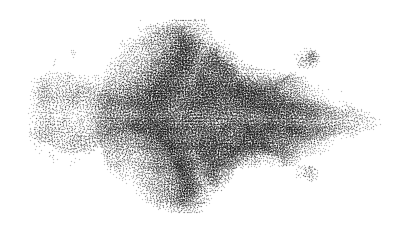

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes.set_aspect('equal')
axes.scatter(coordinates[:, 1], coordinates[:, 0], s=1, color='k', alpha=0.2, marker='.', linewidths=0.45)
axes.axis('off')
plt.show()

Log-weight distribution rtrbm

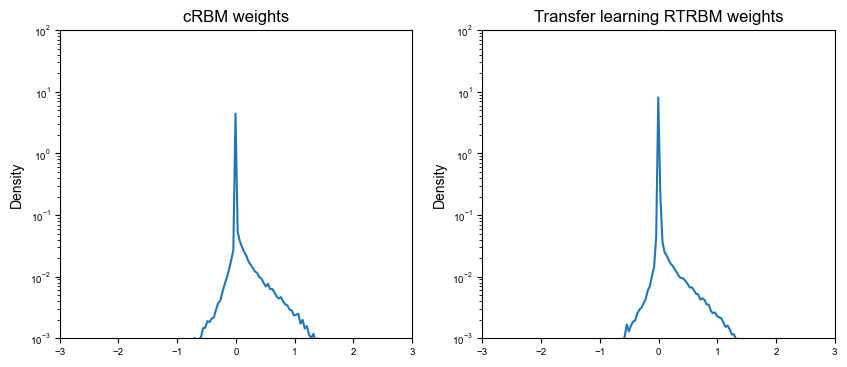

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.kdeplot(rbm.weights.ravel(), log_scale=[0, 10], ax=ax[0])
ax[0].set_ylim([1e-3, 1e2])
ax[0].set_xlim([-3, 3])
ax[0].set_title('cRBM weights')

sns.kdeplot(rtrbm.W.ravel().cpu(), log_scale=[0, 10],ax=ax[1])
ax[1].set_ylim([1e-3, 1e2])
ax[1].set_xlim([-3, 3])
ax[1].set_title('Transfer learning RTRBM weights')
plt.show()

Connectivity to hidden layer

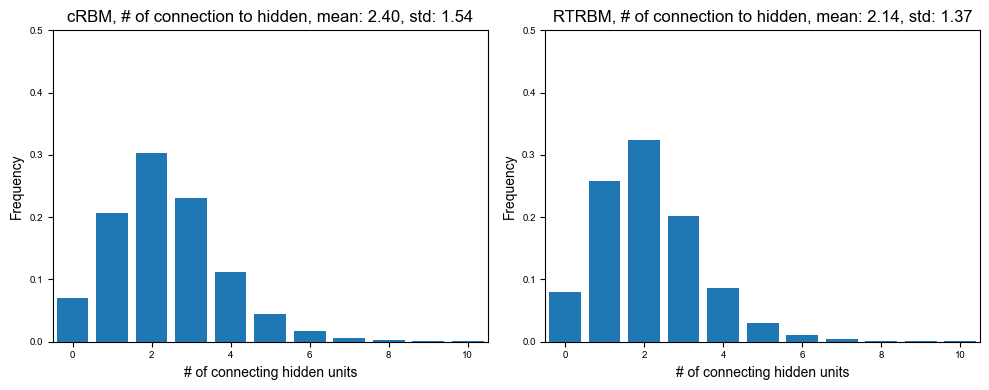

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
th=0.1
n_connections = np.sum(1.0 * (np.abs(rbm.weights)>th), 0)
n_connections = n_connections[n_connections<40]
n_con, freq = np.unique(n_connections, return_counts=True)
ax[0].bar(n_con, freq/sum(freq))
# sns.kdeplot(n_connections)
ax[0].set_title('cRBM, # of connection to hidden, mean: %.4s, std: %.4s'%(float(np.mean(n_connections)), float(np.std(n_connections))))
ax[0].set_xlabel('# of connecting hidden units')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim([-0.5, 10.5])
ax[0].set_ylim([0, 0.5])

n_connections = torch.sum(1.0 * (torch.abs(W)>th), 0)
n_connections = n_connections[n_connections<40]
n_con, freq = torch.unique(n_connections, return_counts=True)
ax[1].bar(n_con, freq/sum(freq))
# sns.kdeplot(n_connections)
ax[1].set_title('RTRBM, # of connection to hidden, mean: %.4s, std: %.4s'%(float(torch.mean(n_connections)), float(torch.std(n_connections))))
ax[1].set_xlabel('# of connecting hidden units')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim([-0.5, 10.5])
ax[1].set_ylim([0, 0.5])
plt.tight_layout()
plt.show()

Suggestive temporal connection between neural assemblies

c:\users\sebas\ru\rtrbm\rtrbm\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\users\sebas\ru\rtrbm\rtrbm\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


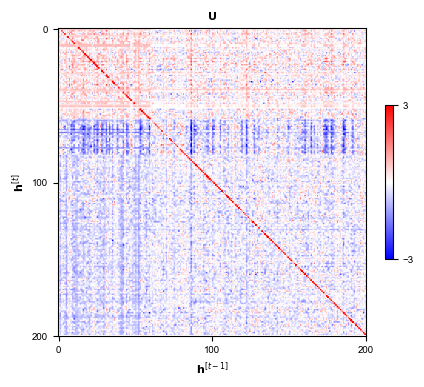

In [21]:
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(U)
idx_U_sorted = np.argsort(kmeans.fit_predict(U))
U_ = U[idx_U_sorted, :].detach()
U_ = U_[:, idx_U_sorted]
W_ = W[idx_U_sorted, :].detach()

fig, axes = plt.subplots(1, 1, figsize=(5, 4))
cm = axes.imshow(U_, plt.get_cmap('bwr'), aspect='equal', vmin=-3, vmax=3)
cb = fig.colorbar(cm, ax=axes, shrink=.5, ticks=[-3, 3])
cb.ax.tick_params(axis='both', which='major', labelsize=7)
axes.set_xlabel(r'$\mathbf{h}^{[t-1]}$', fontsize=8)
axes.set_ylabel(r'$\mathbf{h}^{[t]}$', fontsize=8)
axes.set_title(r'$\mathbf{U}$', fontsize=8)
axes.set_xticks([0, 100, 200])
axes.set_xticklabels([0, 100, 200], fontsize=7)
axes.set_yticks([0, 100, 200])
axes.set_yticklabels([0, 100, 200], fontsize=7)
plt.show()


Receptive field of hidden units (neural assemblies) color coded

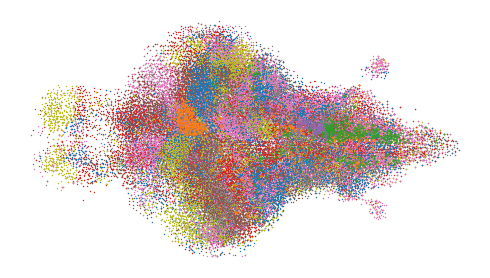

In [22]:
it_color = 0
color_list = ['tab:blue', 'tab:red', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_sub = ['tab:orange', 'tab:green', 'tab:purple']
strongest_connections = np.argmax(np.abs(W_), 0)
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.set_aspect('equal')

for i in range(rtrbm.n_hidden): # 200 hiddens units
    color=color_list[it_color]
    it_color+=1
    if i % 6 == 0:
        it_color = 0

    RF_hi = coordinates[torch.where((torch.abs(W_[i, :])>th))[0], :]
    #idx = coordinates[np.where(strongest_connections==h), :]
    ax.scatter(RF_hi[:, 1], RF_hi[:, 0], marker='.', s=1, linewidths=0.5, color=color)
it_color = 0
for i, h in enumerate([0, 7, 124, 143]): # 200 hiddens units
    color=color_sub[it_color]
    it_color+=1
    if i % 3 == 0:
        it_color = 0
    RF_hi = coordinates[torch.where((torch.abs(W_[h, :])>th))[0], :]
    #idx = coordinates[np.where(strongest_connections==h), :]
    ax.scatter(RF_hi[:, 1], RF_hi[:, 0], marker='.', s=1, linewidths=1, color=color)
ax.axis('off')
plt.tight_layout()
plt.gca()
plt.show()


Moments plot


According to the original paper's methodology, the data is arranged chronologically into 10 batches. Batch 2, 6, and 7 are designated as the test set, while the remaining batches are assigned to the train set. Therefore, the dataset is split into train and test sets following this protocol.

In [26]:
batched_data = reshape(spikes, T=555, n_batches=10, dtype=torch.uint8)
test = batched_data[..., (1, 5, 6)]
train = batched_data[..., (0, 2, 3, 4, 7, 8, 9)]

train_37 = reshape(reshape(train), T=37, n_batches=105, dtype=torch.uint8).float()
test_37 = reshape(reshape(test), T=37, n_batches=45, dtype=torch.uint8).float()

vt, vs_rtrbm, ht_rtrbm, hs_rtrbm = torch.load(path2dir + '/results/figure 3/infer_pre_gibbs_4000_tranfer_whole_brain_rtrbm_sp_5e-07_n_100')
[vs_cRBM, hs_cRBM] = torch.load(path2dir + '/results/figure 3/infer_pre_gibbs_4000_cRBM')
ht_cRBM = rbm.mean_hiddens(reshape(test_37).T).T


C:\Users\sebas\RU\RBM\PGM\source\layer.py:1188: RuntimeWarning: overflow encountered in true_divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)


Determine the statistical properties of both the model and the initial data.

In [36]:
n_v, T = vt.shape
idx = np.random.permutation(n_v)[:10000]

vt = vt[idx, :]
vs_cRBM = vs_cRBM[idx, :]
vs_rtrbm = vs_rtrbm[idx, :]

vvs_cRBM = torch.einsum('vT, VT -> vV', vs_cRBM, vs_cRBM) / T
vvs_rtrbm = torch.einsum('vT, VT -> vV', vs_rtrbm, vs_rtrbm) / T
vvt = torch.einsum('vT, VT -> vV', vt, vt) / T

vvs_cRBM_t = torch.einsum('vT, VT -> vV', vs_cRBM[:, :-1], vs_cRBM[:, 1:]) / (T-1)
vvs_rtrbm_t = torch.einsum('vT, VT -> vV', vs_rtrbm[:, :-1], vs_rtrbm[:, 1:]) / (T-1)
vvt_t = torch.einsum('vT, VT -> vV', vt[:, :-1], vt[:, 1:]) / (T-1)

hhs_cRBM_t = torch.einsum('vT, VT -> vV', torch.tensor(hs_cRBM[:, :-1]), torch.tensor(hs_cRBM[:, 1:]))/ (T-1)
hht_cRBM_t = torch.einsum('vT, VT -> vV', torch.tensor(ht_cRBM[:, :-1]), torch.tensor(ht_cRBM[:, 1:]))/ (T-1)
hhs_rtrbm_t = torch.einsum('vT, VT -> vV', hs_rtrbm[:, :-1], hs_rtrbm[:, 1:]) / (T-1)
hht_rtrbm_t = torch.einsum('vT, VT -> vV', ht_rtrbm[:, :-1], ht_rtrbm[:, 1:]) / (T-1)

vvs_cRBM = vvs_cRBM.flatten()
vvs_rtrbm = vvs_rtrbm.flatten()
vvt = vvt.flatten()

vvs_cRBM_t = vvs_cRBM_t.flatten()
vvs_rtrbm_t = vvs_rtrbm_t.flatten()
vvt_t = vvt_t.flatten()

hhs_cRBM_t = hhs_cRBM_t.flatten()
hht_cRBM_t = hht_cRBM_t.flatten()

hhs_rtrbm_t = hhs_rtrbm_t.flatten()
hht_rtrbm_t = hht_rtrbm_t.flatten()

C:\Users\sebas\AppData\Local\Temp\ipykernel_3136\3425862792.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hhs_cRBM_t = torch.einsum('vT, VT -> vV', torch.tensor(hs_cRBM[:, :-1]), torch.tensor(hs_cRBM[:, 1:]))/ (T-1)


Now we can plot all the statistics

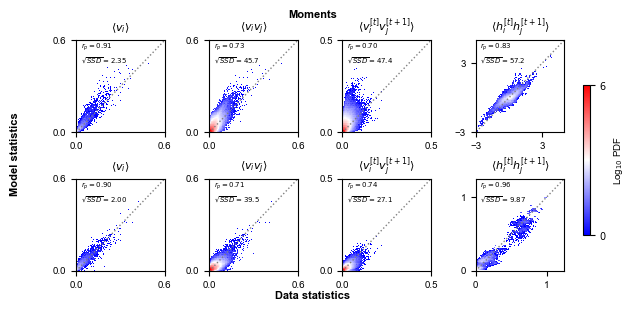

Top row are the statistics of the cRBM. The bottom row are the statistics of the RTRBM 
When an allocation error occurs try to set the number of units plot (idx line 197) at a lower level


In [39]:

def density_scatter(x, y, ax=None, fig=None, r=None, vmax=None, n_bins=100, last=False):
    if ax is None:
        fig, ax = plt.subplots()

    x, y = np.array(x), np.array(y)
    x[np.isnan(x)], y[np.isnan(y)]  = 0, 0
    hh = ax.hist2d(x, y, bins=(n_bins, n_bins), cmap=plt.get_cmap('bwr'), norm=LogNorm(vmin=1, vmax=vmax))

    if last:
        cbar_ax = fig.add_axes([0.93, 0.23, 0.01, 0.5])
        cbar = fig.colorbar(hh[3], pad=0.35, cax=cbar_ax, ticks=[1, vmax])
        cbar.minorticks_off()
        cbar.formatter = LogFormatterExponent(base=10)
        cbar.ax.set_ylabel('Log$_{10}$ PDF', fontsize=7)
        cbar.update_ticks()
        cbar.ax.set_yticklabels(['$0$', '$6$'], fontsize=7)
    else: cbar=0

    temp = y - x
    sSSD = np.sqrt(np.dot(temp.T, temp))
    if r is None:
        r, pvalue = pearsonr(x, y)
    ax.text(.05, .9, '$r_p=%0.4s$'%(r), transform=ax.transAxes, fontsize=5, fontweight='heavy')
    ax.text(.05, .75, '$\\sqrt{SSD}=%0.4s$'%(sSSD), transform=ax.transAxes, fontsize=5, fontweight='heavy')
    # print(pvalue)
    # print(ranksums(x, y))
    return ax, cbar

fs=8

fig, axes = plt.subplots(2, 4, figsize=(6.3, 3))
fig.subplots_adjust(right=0.9, wspace=0.5, hspace=0.5)

ax = axes[0, 0]
ax, cbar = density_scatter(torch.mean(vt, 1), torch.mean(vs_cRBM, 1), ax=ax, fig=fig, vmax=1e6)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .6])
ax.set_ylim([0, .6])
ax.set_xticks([0, .6])
ax.set_yticks([0, .6])
ax.set_title('$\langle v_i \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)

ax = axes[0, 1]
ax, cbar = density_scatter(vvt, vvs_cRBM, ax=ax, fig=fig, vmax=1e6)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .6])
ax.set_ylim([0, .6])
ax.set_xticks([0, .6])
ax.set_yticks([0, .6])
ax.set_title('$\langle v_iv_j \\rangle$', fontsize=fs)
#ax.set_title('$\langle v_iv_j \\rangle-\langle v_i \\rangle \langle v_j \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)

ax = axes[0, 2]
ax, cbar = density_scatter(vvt_t, vvs_cRBM_t, ax=ax, fig=fig, vmax=1e6)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .5])
ax.set_ylim([0, .5])
ax.set_xticks([0, .5])
ax.set_yticks([0, .5])
ax.set_title('$\langle v_i^{[t]}v_j^{[t+1]} \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)

ax = axes[0, 3]
ax, cbar = density_scatter(hht_cRBM_t, hhs_cRBM_t, ax=ax, fig=fig, vmax=1e6)
ax.plot([-5, 5], [-5, 5], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([-3, 5])
ax.set_ylim([-3, 5])
ax.set_xticks([-3, 3])
ax.set_yticks([-3, 3])
ax.set_title('$\langle h_i^{[t]}h_j^{[t+1]} \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)

ax=axes[1, 0]
ax, cbar = density_scatter(np.mean(np.array(vt), 1), np.mean(np.array(vs_rtrbm), 1), ax=ax, fig=fig, vmax=1e6)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .6])
ax.set_ylim([0, .6])
ax.set_xticks([0, .6])
ax.set_yticks([0, .6])
ax.set_title('$\langle v_i \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)

ax = axes[1, 1]
ax, cbar = density_scatter(vvt, vvs_rtrbm, ax=ax, fig=fig, vmax=1e6)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
# ax.plot(covt.flatten(), covs.flatten(), '.', markersize=1)
ax.set_xlim([0, 0.6])
ax.set_ylim([0, 0.6])
ax.set_xticks([0, 0.6])
ax.set_yticks([0, 0.6])
ax.set_title('$\langle v_iv_j \\rangle$', fontsize=fs)
#ax.set_title('$\langle v_iv_j \\rangle-\langle v_i \\rangle \langle v_j \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)

ax = axes[1, 2]
ax, cbar = density_scatter(vvt_t, vvs_rtrbm_t, ax=ax, fig=fig, vmax=1e6)
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .5])
ax.set_ylim([0, .5])
ax.set_xticks([0, .5])
ax.set_yticks([0, .5])
ax.set_title('$\langle v_i^{[t]}v_j^{[t+1]} \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)

ax = axes[1, 3]
ax, cbar = density_scatter(hht_rtrbm_t, hhs_rtrbm_t, ax=ax, fig=fig, vmax=1e6, last=True)
ax.plot([0, 2], [0, 2], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, 1.25])
ax.set_ylim([0, 1.25])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_title('$\langle h_i^{[t]}h_j^{[t+1]} \\rangle$', fontsize=fs)
ax.tick_params(labelsize=7)

fig.suptitle('Moments', fontsize=fs, fontweight='bold')
fig.supxlabel('Data statistics', fontsize=fs, fontweight='bold')
fig.supylabel('Model statistics', fontsize=fs, fontweight='bold')
plt.show()

print('Top row: cRBM statistics. The bottom row: RTRBM statistics\n'
      'When an allocation error occurs try to set the number of units plot (idx line 197) at a lower level')